### Пайплайн распознавания лиц

Обычно система распознавания лиц состоит из трех элементов:

- детекция лица (face detection);
- выравнивание лица (face alignment);
- распознавания лица (face recognition).

In [89]:
import torch
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import torch.nn as nn
import torchvision.transforms.functional as TF
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
import math
import skimage.io
from torch.utils.data import Dataset

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [6]:
PATH_TO_IMAGE = './data/test_img2.jpg'

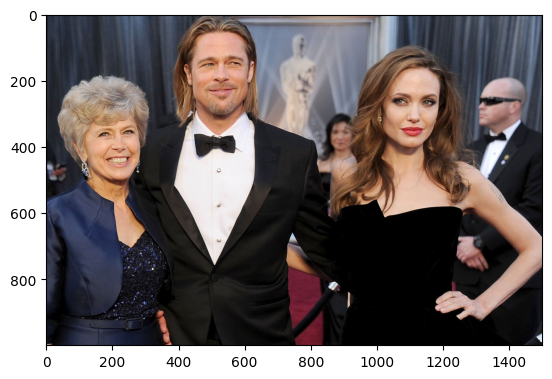

In [43]:
image = cv2.imread(PATH_TO_IMAGE)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image);

# detection

In [7]:
def detect_faces(PATH_TO_IMAGE, min_face_size=200):
    image = cv2.imread(PATH_TO_IMAGE)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(image)

    mtcnn = MTCNN(keep_all=True, device=device, min_face_size=min_face_size)
    boxes, _ = mtcnn.detect(img)
    boxes = np.array(boxes, dtype=np.float32)

    if boxes.shape:
        crop_image_list = []
        for box in boxes:  
            x1 = int(box[1])
            x2 = int(box[3])
            y1 = int(box[0])
            y2 = int(box[2])
            crop_img = image[x1:x2,y1:y2:]
            crop_image_list.append(crop_img)

    return crop_image_list

In [14]:
crop_image_list = detect_faces(PATH_TO_IMAGE, min_face_size=200)

(228, 171, 3)


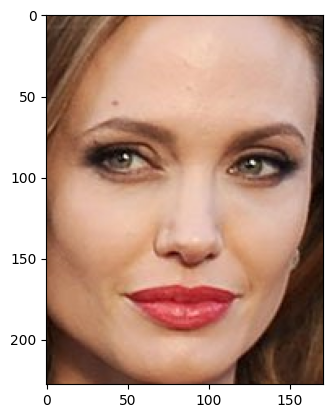

(232, 169, 3)


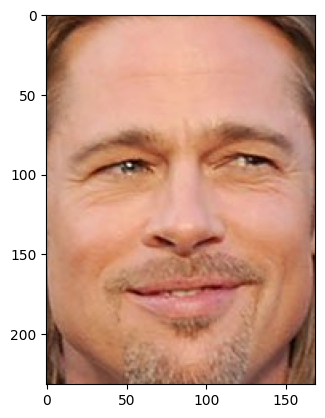

(210, 166, 3)


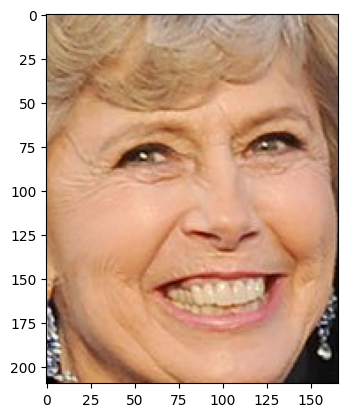

In [38]:
for crop_img in crop_image_list:
    print(crop_img.shape)
    plt.imshow(crop_img)
    plt.pause(0.001);

# alignment

In [18]:
class ModelLandmark(nn.Module):
    def __init__(self, model, n_classes):
        super(ModelLandmark, self).__init__()
        self.model = model
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, n_classes)
        

    def forward(self, x):
        x=self.model(x)
        return x

In [19]:
model = torch.load('./models/model_alignment.bin', map_location=torch.device('cpu'))

In [20]:
def get_landmarks(img):
    img = TF.to_tensor(img)
    img = TF.resize(img, (224,224))
    img = TF.normalize(img, [0.5], [0.5])
    img = img[None,:,:,:]
    
    model.eval()
    with torch.no_grad():
        inputs = img
        outputs = model(inputs)
        outputs = (outputs + 0.5) * 224
        outputs = outputs.view(-1, 68, 2)
    return inputs[0].numpy(), outputs[0].numpy()

In [21]:
def find_angle(image, eyePoints):
    leftEyeX,leftEyeY = eyePoints[0]
    rightEyeX, rightEyeY = eyePoints[1]
    angle = math.atan( (leftEyeY - rightEyeY) / (leftEyeX - rightEyeX) ) * (180/math.pi)
    return angle

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

In [33]:
def get_align_img(img, landmarks):
    eyePoints = (landmarks[39], landmarks[42])
    angle = find_angle(img, eyePoints)
    align_img = rotate_image(img, angle)
    return align_img

In [41]:
align_img_list = []
for img in crop_image_list:
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, landmarks = get_landmarks(gray_img)
    final_align_img = get_align_img(img, landmarks)
    align_img_list.append(final_align_img)

(228, 171, 3)


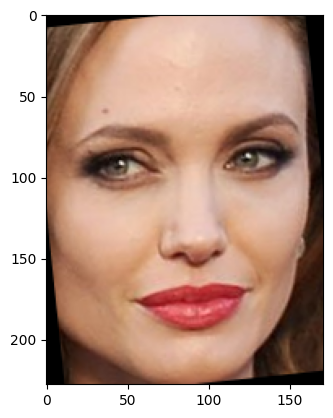

(232, 169, 3)


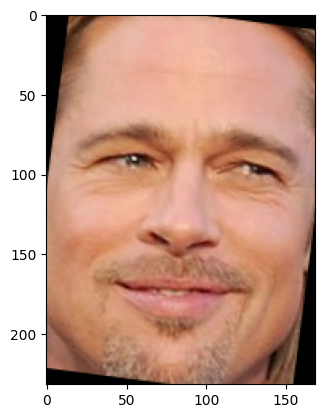

(210, 166, 3)


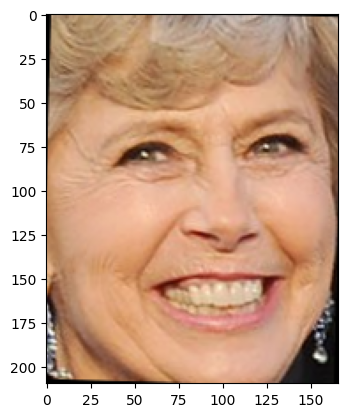

In [42]:
for align_img in align_img_list:
    print(align_img.shape)
    plt.imshow(align_img)
    plt.pause(0.001);

# recognition

### classification

In [44]:
model = torch.load('./models/model_ce.bin', map_location=torch.device('cpu'))

In [66]:
model.eval()

img_classes = []
with torch.no_grad():
    for face in align_img_list:
        face = TF.to_tensor(face)
        face = face[None,:,:,:]
        face = face.to(device)
        outputs = model(face)
        _, predicted = torch.max(outputs, 1)
        img_classes.append(predicted.numpy()[0])

In [68]:
img_classes

[380, 461, 125]

let's draw images from this classes with our original image

In [75]:
df_attrs = pd.read_csv("./data/celebA_train_500/celebA_anno.txt", header=None, sep=' ')
df_attrs.columns = ['name_img', 'id']

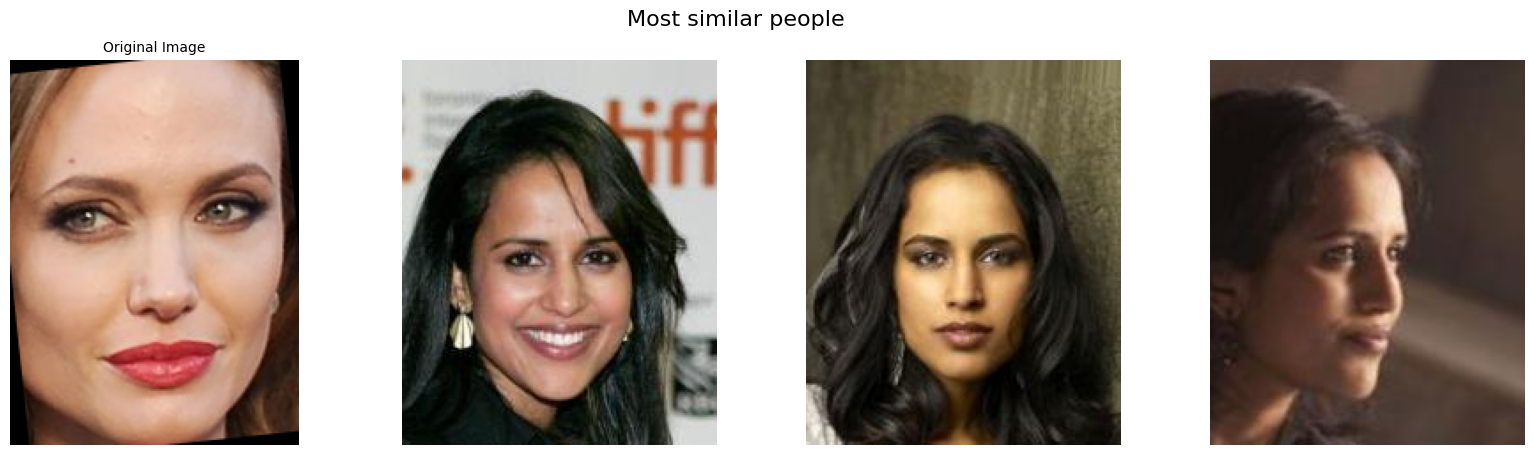

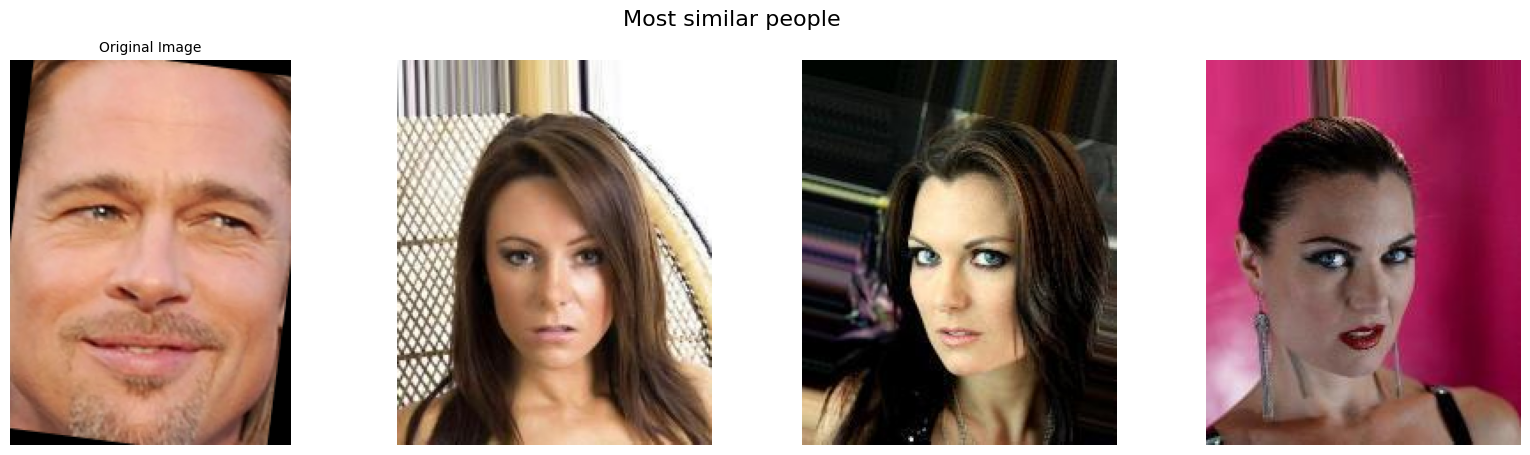

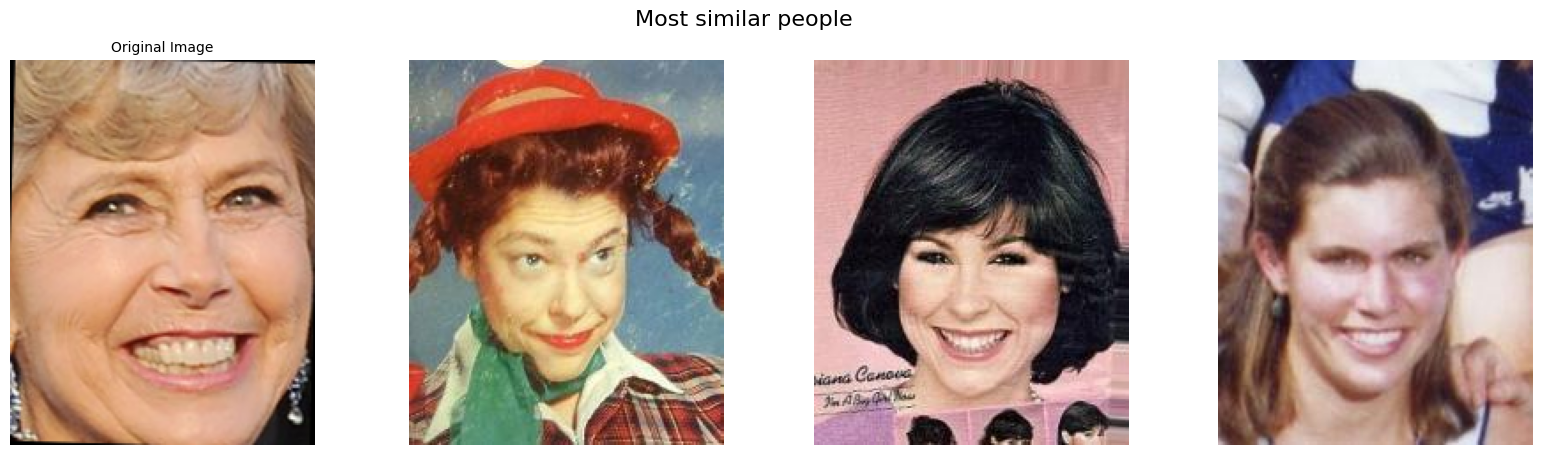

In [86]:
for i in range(len(align_img_list)):
    # take 3 images from this class
    same_class_images = list(df_attrs[df_attrs['id'] == img_classes[i]]['name_img'])[:3]
    
    fig, axes = plt.subplots(1, len(same_class_images) + 1, figsize=((len(same_class_images) + 1) * 5, 5))

    axes[0].imshow(align_img_list[i])
    axes[0].set_title("Original Image", fontsize=10)
    axes[0].axis('off')

    # Assuming top5 is a list of tuples containing (name_img, sim_img)
    for ax, name_img in zip(axes[1:], same_class_images):
        img2 = skimage.io.imread(f"./data/celebA_train_500/celebA_imgs/{name_img}")
        ax.imshow(img2)
        ax.axis('off')

    fig.suptitle("Most similar people", fontsize=16)
    plt.show()
    plt.pause(0.001);

Brad Pitt is not the best :(  Probably we don't have a lot of men in our sample for train (we should add more data for train classification model in future)  
Others are not so bad


### embeddings

In [87]:
class ModelWithoutLastLayer(nn.Module):
    def __init__(self, model):
        super(ModelWithoutLastLayer, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        return self.features(x)
    
model_without_last_layer = ModelWithoutLastLayer(model)

In [92]:
def compute_embeddings(model, align_img_list):
    '''
      compute embeddings from the trained model for list of images.
      params:
        model: trained nn model that takes images and outputs embeddings
        images_list: list of images paths to compute embeddings for
      output:
        list: list of model embeddings. Each embedding corresponds to images
              names from images_list
    '''    
    model.eval()
    embeddings = []
    with torch.no_grad():
        for img in align_img_list:
            img = TF.to_tensor(img)
            img = TF.resize(img, (224,224))
            img = TF.normalize(img, [0.5], [0.5])
            img = img[None,:,:,:]
    
            img = img.to(device)
            outputs = model(img).detach().cpu().numpy()
            outputs = [list(i.flatten()) for i in outputs]            
            embeddings.extend(outputs)
       
    return embeddings

In [93]:
img_embeddings = compute_embeddings(model_without_last_layer, align_img_list)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [95]:
len(img_embeddings)

3

In [97]:
def cosine_similarity(v1,v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

In [100]:
cos_sim = []
for i in range(len(img_embeddings)):
    for j in range(i+1,len(img_embeddings)):
        cs = cosine_similarity(img_embeddings[i], img_embeddings[j])
        cos_sim.append(cs)

In [101]:
cos_sim

[0.7790028, 0.76853454, 0.8577575]

Andjelina and Brad -> 0.7790028  
Andjelina and other woman -> 0.76853454  
Brad and other woman -> 0.8577575 (probably she's his mother :))  

we can see that all starts looks similar with each other, espessially Brad and other woman